**spring = march, april, may**

**summer = june, july, august**

juneteenth (only in 2021)

july 4th

august has no holidays 

**fall = september, october, november**

**winter = december, january, februrary**

https://www.mikulskibartosz.name/time-in-machine-learning/



In [1]:
import tensorflow 
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import joblib
from tensorflow import keras
from google.colab import drive
import os
import random
import math

drive.mount('/content/drive/', force_remount=True)
pd.options.mode.chained_assignment = None

Mounted at /content/drive/


# Functions

In [2]:
#purpose: scale the values of data points to be between 0 -> 1
#input: df = dataframe
#output: df = scaled df, allScalers = scalers for all variables

def scaleAllData(df, skip = 'is_weekend'):
    allScalers = []
    for column in df.columns:
      scaler = MinMaxScaler(feature_range=(0,1))
      df1 = df[column]
      df[column] = scaler.fit_transform(np.array(df1.values.reshape(-1, 1)))
      allScalers.append(scaler)
    return df, allScalers

In [3]:
#purpose: split data into the inputs and output prediction values
#input: df = dataframe, predictColPos = position of the var that you want to predict, window_size = timesteps, default is 1
#output: X = input data, y = what you want to predict data

def df_to_X_y(df, predictColPos, window_size= 1): #1 day of feature data
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)- window_size):
        row = [ r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][predictColPos] 
        y.append(label)
    return np.array(X), np.array(y)

In [4]:
#purpose: make df; meaning it has all the weather var values scaled, the is weekend/weekday split, and megawatts
#inputs: df = dataframe, cols = the columns that we should have as mentioned above, directory = where to save scalers to, beg = position of df to start from, end = position of df to end at
#outputs: prepared df

# select df for specific season; I am choosing summer
def prepareDf(df, cols_rearranged, baseLSTM_Directory, location, numDaysInMonth, beg = 0, end = -1):
  df = df.iloc[beg:end, :]
  df['date'] = pd.to_datetime(df['date'], format='%m-%dT%H:%M:%S')
  df['date']= df["date"].map(lambda x: x.replace(year=2019))
  df.index = df['date']
  
  df['Seconds'] = df.index.map(pd.Timestamp.timestamp)
  day = 60 * 60 * 24 #60 s in a min, 60 min in an hour, 24 hours in a day
  month = numDaysInMonth * 60 * day #num seconds in a month of AUGUST
  df['Day sin'] = np.sin(df['Seconds']*2*(np.pi/day))
  df['Day cos'] = np.cos(df['Seconds']*2*(np.pi/day))
  df['Month sin'] = np.sin(df['Seconds']*2*(np.pi/month))
  df['Month cos'] = np.cos(df['Seconds']*2*(np.pi/month))
  
  # starting from 06-01 which is a Sunday in 2019
  # dates are from 0 - 6
  # 0 1 2 3 4 5 6
  # M T W T F S S
  df['date'] = pd.to_datetime(df.date)
  df['day_of_week'] = df.date.dt.weekday
  # I want Sat/Sun to be treated the same, because they are both a weekend 
  df['is_weekend'] = df['day_of_week'].isin([5, 6])
  df['is_weekend'] = df['is_weekend'].astype(int)
  df.drop('date', axis=1, inplace=True)
  df.drop('day_of_week', axis=1, inplace=True)  

  df = df[cols_rearranged]

  #scaling and saving scalers
  return df

In [5]:
#purpose: generate a energy consumption model 
#input: df=dataframe, numEpochs = epochs for model training, baseLSTM_Directory = directory for LSTM, location = place sf/sac/sd/etc.
#output: rmse = rmse value, model = the model that resulted in that rmse value

def energyConsumptionModel(df, numEpochs, baseLSTM_Directory, location, window_size):
    megawattsPos = len(df.columns) - 1
    X, y = df_to_X_y(df, megawattsPos, window_size)

    #############################################train and test #########################################################
    #456 data points 456/24 = 20 days, weekends are excluded (2019)
    #each data point is 24 
    # 80% data = day 0-15 is 16 days -> 360
    # 20% data = day 16-19 is 4 days -> 96

    allIndex = []
    for i in range(0, len(X), window_size): #get the indices for days in the month
      allIndex.append(i)

    random.shuffle(allIndex) #shuffle the indices of the day
    train_size =  round(len(X)/window_size * 0.8)* window_size

    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    ############################################# create model #########################################################
    model = Sequential()
    model.add(LSTM(64,input_shape=(X_train.shape[1],X_train.shape[2]))) # input layer; 31 data inputs, 1 step (1 hr)
    model.add(Dense(32, 'relu')) #hidden layer 1
    model.add(Dense(32, 'relu')) #hidden layer 2
    model.add(Dense(1, 'linear')) #output layer
    
    storeModel = baseLSTM_Directory + 'model' + location +'/'
    
    cp = ModelCheckpoint(storeModel, save_best_only = True) #I want to only save the best model (lowest validation loss)
    model.compile(loss = MeanSquaredError(), optimizer = Adam(), metrics = [RootMeanSquaredError()])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = numEpochs, callbacks = [cp])

    ######################################### predictions and rmse ######################################################
    train_predictions = model.predict(X_train).flatten()
    train_results = pd.DataFrame(data = {'Train Predictions': train_predictions, 'Actuals':y_train})
    rmse = mean_squared_error(train_predictions, y_train, squared=False)
    print("RMSE value: ", rmse)
    return rmse, model, allIndex

In [6]:
#purpose: make the final future energy consumption predictions for future hours
#input: bestEnergyConsumptionModel = best model to do prediction, data = prev day so that we can make future predictions, howManyFutureHours = how many hours to predict, window_size = timesteps, numVarInputs = number of variables for the model (energy consumption, weather data vars)
#output: future energy consumption
# futurePredictions_EC(bestEnergyConsumptionModel, df2021, howManyFutureHours, window_size, numVarInputs)
def futurePredictions_EC(bestEnergyConsumptionModel, dataForPrediction, howManyFutureHours, window_size, numVarInputs):
    future_outputs=[]
    i=0
    while(i<howManyFutureHours): #for the next thirty hours
      x_input = np.array(dataForPrediction.iloc[i:window_size+i, :])
      # print("i : ", i)
      # print('x_input: ', x_input)
      # print(x_input.shape)
      x_input = x_input.reshape(1, window_size, numVarInputs)
      yhat = bestEnergyConsumptionModel.predict(x_input, verbose=0)#.flatten()
      # print('future data: ', yhat[0])
      future_outputs.append(yhat[0][0])
      i=i+1

    return future_outputs

In [7]:
def printMonth_july(date_2021, dayInJuly):
  pathToData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/CAISO_NetDemand_Megawatts_google/' 
  pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-Season_REDO/july/' 
  
  dates2019 = ['20190701','20190702','20190703','20190704','20190705','20190706','20190707','20190708','20190709','20190710',
               '20190711','20190712','20190713','20190714','20190715','20190716','20190717','20190718','20190719',
               '20190720','20190721','20190722','20190723','20190724','20190725','20190726','20190727','20190728','20190729','20190730','20190731']
  dates2020 = ['20200701','20200702','20200703','20200704','20200705','20200706','20200707','20200708','20200709','20200710',
               '20200711','20200712','20200713','20200714','20200715','20200716','20200717','20200718','20200719','20200720',
               '20200721','20200722','20200723','20200724','20200725','20200726','20200727','20200728','20200729','20200730','20200731']
  dates2021 = ['20210701','20210702','20210703','20210704','20210705','20210706','20210707','20210708','20210709','20210710','20210711',
               '20210712','20210713','20210714','20210715','20210716','20210717','20210718','20210719','20210720','20210721','20210722',
               '20210723','20210724','20210725','20210726','20210727','20210728','20210729','20210730','20210731']
  july = ['07-01','07-02','07-03','07-04','07-05','07-06','07-07','07-08','07-09','07-10','07-11','07-12','07-13','07-14','07-15',
          '07-16','07-17','07-18','07-19','07-20','07-21','07-22','07-23','07-24','07-25','07-26','07-27','07-28','07-29','07-30','07-31']
  
  xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
  beg = 'CAISO-netdemand-'
  end = '-Megawatts.csv'
  rms2019_2020 = 0
  rms2019_2021 = 0
  rms2020_2021 = 0

  read2021 = pathToData + beg + date_2021 + end
  df2021 = pd.read_csv(read2021)
 
  return df2021['Megawatts']


In [8]:
def just_energyDemand(date_2019, date_2020, date_2021, july_date, iteration):
  pathToData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/CAISO_NetDemand_Megawatts_google/' 
  pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/all/' 
  
  dates2019 = ['20190701','20190702','20190703','20190704','20190705','20190706','20190707','20190708','20190709','20190710',
               '20190711','20190712','20190713','20190714','20190715','20190716','20190717','20190718','20190719',
               '20190720','20190721','20190722','20190723','20190724','20190725','20190726','20190727','20190728','20190729','20190730','20190731']
  dates2020 = ['20200701','20200702','20200703','20200704','20200705','20200706','20200707','20200708','20200709','20200710',
               '20200711','20200712','20200713','20200714','20200715','20200716','20200717','20200718','20200719','20200720',
               '20200721','20200722','20200723','20200724','20200725','20200726','20200727','20200728','20200729','20200730','20200731']
  dates2021 = ['20210701','20210702','20210703','20210704','20210705','20210706','20210707','20210708','20210709','20210710','20210711',
               '20210712','20210713','20210714','20210715','20210716','20210717','20210718','20210719','20210720','20210721','20210722',
               '20210723','20210724','20210725','20210726','20210727','20210728','20210729','20210730','20210731']
  # july = ['07-01','07-02','07-03','07-04','07-05','07-06','07-07','07-08','07-09','07-10','07-11','07-12','07-13','07-14','07-15',
  #         '07-16','07-17','07-18','07-19','07-20','07-21','07-22','07-23','07-24','07-25','07-26','07-27','07-28','07-29','07-30','07-31']
  july = ['July 1','July 2','July 3','July 4','July 5','July 6','July 7','July 8','July 9','July 10','July 11','July 12','July 13','July 14','July 15',
          'July 16','July 17','July 18','July 19','July 20','July 21','July 22','July 23','July 24','July 25','July 26','July 27',
          'July 28','July 29','July 30','July 31']
  
  xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
  beg = 'CAISO-netdemand-'
  end = '-Megawatts.csv'
  rms2019_2020_2021 = 0
  rms2019_2021 = 0
  rms2020_2021 = 0

  read2019 = pathToData + beg + date_2019 + end
  read2020 = pathToData + beg + date_2020 + end
  read2021 = pathToData + beg + date_2021 + end
  
  df2019 = pd.read_csv(read2019)
  df2020 = pd.read_csv(read2020)
  df2021 = pd.read_csv(read2021)
  training = pd.concat([df2019, df2020], axis=1)
  training['Mean'] = training.mean(axis=1)

  rms2019_2020_2021 += round(mean_squared_error(training['Mean'], df2021['Megawatts'], squared=False), 2)

  plt.plot(training['Mean'], color = 'red', label = 'Training', linestyle="dotted")
  plt.plot(df2021['Megawatts'], color = 'lime', label = 'Testing')
  plt.xticks(xaxis)
  plt.xlabel('Hours')
  plt.ylabel('Megawatts')
  print(july[july_date])
  plt.suptitle(july[july_date] +" - Training vs. Testing Energy Demand", weight = "bold")
  plt.title('Offset:' + str(rms2019_2020_2021))
  plt.legend()
  plt.savefig(pathToSaveData+str(july[july_date])+'_groundTruth_'+str(iteration)+'.jpg', bbox_inches = 'tight', dpi=150)
  plt.show()

In [9]:
def getEnergy_july(date_2019, date_2020, date_2021, july_date):
  pathToData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/CAISO_NetDemand_Megawatts_google/' 
  pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/all/' 
  
  dates2019 = ['20190701','20190702','20190703','20190704','20190705','20190706','20190707','20190708','20190709','20190710',
               '20190711','20190712','20190713','20190714','20190715','20190716','20190717','20190718','20190719',
               '20190720','20190721','20190722','20190723','20190724','20190725','20190726','20190727','20190728','20190729','20190730','20190731']
  dates2020 = ['20200701','20200702','20200703','20200704','20200705','20200706','20200707','20200708','20200709','20200710',
               '20200711','20200712','20200713','20200714','20200715','20200716','20200717','20200718','20200719','20200720',
               '20200721','20200722','20200723','20200724','20200725','20200726','20200727','20200728','20200729','20200730','20200731']
  dates2021 = ['20210701','20210702','20210703','20210704','20210705','20210706','20210707','20210708','20210709','20210710','20210711',
               '20210712','20210713','20210714','20210715','20210716','20210717','20210718','20210719','20210720','20210721','20210722',
               '20210723','20210724','20210725','20210726','20210727','20210728','20210729','20210730','20210731']
  july = ['07-01','07-02','07-03','07-04','07-05','07-06','07-07','07-08','07-09','07-10','07-11','07-12','07-13','07-14','07-15',
          '07-16','07-17','07-18','07-19','07-20','07-21','07-22','07-23','07-24','07-25','07-26','07-27','07-28','07-29','07-30','07-31']
  
  xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
  beg = 'CAISO-netdemand-'
  end = '-Megawatts.csv'

  read2019 = pathToData + beg + date_2019 + end
  read2020 = pathToData + beg + date_2020 + end
  read2021 = pathToData + beg + date_2021 + end

  df2019 = pd.read_csv(read2019)
  df2020 = pd.read_csv(read2020)
  df2021 = pd.read_csv(read2021)
  training = pd.concat([df2019, df2020], axis=1)
  training['Mean'] = training.mean(axis=1)

  return training['Mean'], df2021['Megawatts'] #diff from training and diff from testing/2021 prediction data

In [10]:
def percentageOf(prediction, groundTruth):
  allVals = 0
  wholeDay = []
  for i in range(len(prediction)):
    # print("i is: ", str(i))
    # print("groundTruth: ", str(groundTruth[i]))
    # print("prediction: ", str(prediction[i]))
    oneDiff = abs(groundTruth[i] - prediction[i])/ (groundTruth[i])
    allVals+=oneDiff
    wholeDay.append(oneDiff)
    # print(oneDiff)

  return wholeDay, allVals/(len(prediction))

# Run

In [196]:
pathToData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/2019_2020/'
dataFile = [f for f in listdir(pathToData) if isfile(join(pathToData, f))] 
for file in dataFile:
    print(file)
    # df = pd.read_csv(pathToDir + file)

print('-------')
#for now, I will only use SF data 
pos = 3

fileRead = pathToData + dataFile[pos]
print('fileRead: ', fileRead)
df = pd.read_csv(fileRead)
df_sac = pd.read_csv(pathToData + dataFile[0])
df_sf = pd.read_csv(pathToData + dataFile[1])
df_sd = pd.read_csv(pathToData + dataFile[2])
df_la = pd.read_csv(pathToData + dataFile[3])
# 2021 data
pathToData1 = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/2021/'
dataFile1 = [f for f in listdir(pathToData1) if isfile(join(pathToData1, f))] 
for file in dataFile1:
    print(file)
    # df = pd.read_csv(pathToDir + file)
 
fileRead1 = pathToData1 + dataFile1[pos]
print('fileRead: ', fileRead1)
df2021 = pd.read_csv(fileRead1)
df2021_sac = pd.read_csv(pathToData1 + dataFile1[0])
df2021_sf = pd.read_csv(pathToData1 + dataFile1[1])
df2021_sd = pd.read_csv(pathToData1 + dataFile1[2])
df2021_la = pd.read_csv(pathToData1 + dataFile1[3])

howManyFutureHours = 24
window_size = 96
numEpochs = 20
iters = 4
iteration = 3 #1 = 48, 2 = 72, 3 = 96

beg = 4344
end = 5088
numDaysInMonth = 31


baseLSTM_Directory = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/'
locArray = ['_SAC', '_SF', '_SD', '_LA']
location = locArray[pos]
print(location)
##### MAKE SURE YOU CHANGED ALL VARIABLES RELATED TO LOCATION ABOVE BEFORE RUNNING THIS CELL

SAC-yearAvg-NOAA-and-Megawatts.csv
SF-yearAvg-NOAA-and-Megawatts.csv
SD-yearAvg-NOAA-and-Megawatts.csv
LA-yearAvg-NOAA-and-Megawatts.csv
-------
fileRead:  /content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/2019_2020/LA-yearAvg-NOAA-and-Megawatts.csv
SAC-NOAA-and-Megawatts.csv
SF-NOAA-and-Megawatts.csv
SD-NOAA-and-Megawatts.csv
LA-NOAA-and-Megawatts.csv
fileRead:  /content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/2021/LA-NOAA-and-Megawatts.csv
_LA


In [197]:
####sac
df_sac.columns[1:-1]
cols_rearranged = list(df_sac.columns[1:-1])
cols_rearranged.append('is_weekend')
cols_rearranged.append('Day sin')
cols_rearranged.append('Day cos')
cols_rearranged.append('Month sin')
cols_rearranged.append('Month cos')
cols_rearranged.append('AvgMegawatts2019-2020')

df_sac = prepareDf(df_sac, cols_rearranged, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df_sac = df_sac[df_sac.is_weekend == 0] # only keeping weekday data
df_sac.drop('is_weekend', axis = 1, inplace =True)
df_sac, allScalers = scaleAllData(df_sac)

#### sf

cols_rearranged_sf = list(df_sf.columns[1:-1])
cols_rearranged_sf.append('is_weekend')

df_sf = prepareDf(df_sf, cols_rearranged_sf, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df_sf = df_sf[df_sf.is_weekend == 0] # only keeping weekday data
df_sf.drop('is_weekend', axis = 1, inplace =True)

df_sf, discard = scaleAllData(df_sf)

####sd

cols_rearranged_sd = list(df_sd.columns[1:-1])
cols_rearranged_sd.append('is_weekend')

df_sd = prepareDf(df_sd, cols_rearranged_sd, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df_sd = df_sd[df_sd.is_weekend == 0] # only keeping weekday data
df_sd.drop('is_weekend', axis = 1, inplace =True)

df_sd, discard = scaleAllData(df_sd)

####la

cols_rearranged_la = list(df_la.columns[1:-1])
cols_rearranged_la.append('is_weekend')

df_la = prepareDf(df_la, cols_rearranged_la, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df_la = df_la[df_la.is_weekend == 0] # only keeping weekday data
df_la.drop('is_weekend', axis = 1, inplace =True)

df_la, discard = scaleAllData(df_la)

df = pd.concat([df_sf, df_sd, df_la, df_sac], axis=1) # combine all weather variable data into one dataframe, df
# saveScalers(df, baseLSTM_Directory, location, allScalers) #saving scalers
julyFourth =[72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
df.drop(df.index[julyFourth], inplace=True) # remove July 4th

rmse, bestEnergyConsumptionModel, allIndex = energyConsumptionModel(df, numEpochs, baseLSTM_Directory, location, window_size)
# rmse, bestEnergyConsumptionModel, X, y = energyConsumptionModel(df, numEpochs, baseLSTM_Directory, location, window_size)

saveModelsDir = baseLSTM_Directory +'Best'+ location + '/'
bestEnergyConsumptionModel.save(saveModelsDir +'energyModel/', save_format = 'utf')

########################################## GET DATA FOR FUTURE PREDICTION #######################################################

####sac
df2021_sac.columns[1:-1]
cols_rearranged = list(df2021_sac.columns[1:-1])
cols_rearranged.append('is_weekend')
cols_rearranged.append('Day sin')
cols_rearranged.append('Day cos')
cols_rearranged.append('Month sin')
cols_rearranged.append('Month cos')
cols_rearranged.append('Megawatts_2021')

df2021_sac = prepareDf(df2021_sac, cols_rearranged, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df2021_sac = df2021_sac[df2021_sac.is_weekend == 0] # only keeping weekday data
df2021_sac.drop('is_weekend', axis = 1, inplace =True)
df2021_sac, discard = scaleAllData(df2021_sac)

#### sf

cols_rearranged_sf = list(df2021_sf.columns[1:-1])
cols_rearranged_sf.append('is_weekend')

df2021_sf = prepareDf(df2021_sf, cols_rearranged_sf, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df2021_sf = df2021_sf[df2021_sf.is_weekend == 0] # only keeping weekday data
df2021_sf.drop('is_weekend', axis = 1, inplace =True)

df2021_sf, discard = scaleAllData(df2021_sf)

####sd

cols_rearranged_sd = list(df2021_sd.columns[1:-1])
cols_rearranged_sd.append('is_weekend')

df2021_sd = prepareDf(df2021_sd, cols_rearranged_sd, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df2021_sd = df2021_sd[df2021_sd.is_weekend == 0] # only keeping weekday data
df2021_sd.drop('is_weekend', axis = 1, inplace =True)

df2021_sd, discard = scaleAllData(df2021_sd)

####la

cols_rearranged_la = list(df2021_la.columns[1:-1])
cols_rearranged_la.append('is_weekend')

df2021_la = prepareDf(df2021_la, cols_rearranged_la, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df2021_la = df2021_la[df2021_la.is_weekend == 0] # only keeping weekday data
df2021_la.drop('is_weekend', axis = 1, inplace =True)

df2021_la, discard = scaleAllData(df2021_la)

df2021 = pd.concat([df2021_sf, df2021_sd, df2021_la, df2021_sac], axis=1) # combine all weather variable data into one dataframe, df
df2021.drop(df2021.index[julyFourth], inplace=True) #removing July 4th
# # ########################################## FUTURE PREDICTION #######################################################
numVarInputs = len(df2021.columns)
# lastTwoDays = len(df2021) - 48
df2021_clean = df2021
df2021_clean.drop(df2021_clean.index[julyFourth], inplace=True) #removing July 4th


Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 0.0495 - root_mean_squared_error: 0.2225

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/model_LA/assets


12/12 [==============================] - 10s 641ms/step - loss: 0.0495 - root_mean_squared_error: 0.2225 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1067
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0771

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/model_LA/assets


12/12 [==============================] - 8s 702ms/step - loss: 0.0059 - root_mean_squared_error: 0.0771 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793
Epoch 3/20
11/12 [==========================>...] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0662

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/model_LA/assets


12/12 [==============================] - 6s 503ms/step - loss: 0.0045 - root_mean_squared_error: 0.0672 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0588
Epoch 4/20
12/12 [==============================] - 1s 46ms/step - loss: 0.0040 - root_mean_squared_error: 0.0631 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0690
Epoch 5/20
12/12 [==============================] - 1s 45ms/step - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0760
Epoch 6/20
11/12 [==========================>...] - ETA: 0s - loss: 0.0040 - root_mean_squared_error: 0.0632

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/model_LA/assets


12/12 [==============================] - 6s 514ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0367
Epoch 7/20
12/12 [==============================] - 1s 52ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0607
Epoch 8/20
12/12 [==============================] - ETA: 0s - loss: 0.0036 - root_mean_squared_error: 0.0599

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/model_LA/assets


12/12 [==============================] - 5s 454ms/step - loss: 0.0036 - root_mean_squared_error: 0.0599 - val_loss: 8.7604e-04 - val_root_mean_squared_error: 0.0296
Epoch 9/20
12/12 [==============================] - 1s 48ms/step - loss: 0.0035 - root_mean_squared_error: 0.0592 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0535
Epoch 10/20
11/12 [==========================>...] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0569

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/model_LA/assets


12/12 [==============================] - 6s 527ms/step - loss: 0.0032 - root_mean_squared_error: 0.0565 - val_loss: 7.1679e-04 - val_root_mean_squared_error: 0.0268
Epoch 11/20
12/12 [==============================] - 1s 44ms/step - loss: 0.0037 - root_mean_squared_error: 0.0609 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0616
Epoch 12/20
12/12 [==============================] - 1s 44ms/step - loss: 0.0034 - root_mean_squared_error: 0.0585 - val_loss: 8.0880e-04 - val_root_mean_squared_error: 0.0284
Epoch 13/20
12/12 [==============================] - 1s 44ms/step - loss: 0.0036 - root_mean_squared_error: 0.0596 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0482
Epoch 14/20
12/12 [==============================] - 1s 45ms/step - loss: 0.0028 - root_mean_squared_error: 0.0527 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 15/20
12/12 [==============================] - 1s 48ms/step - loss: 0.0026 - root_mean_squared_error: 0.0505 - val_loss: 9.0577e-04 - val

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/Best_LA/energyModel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/Best_LA/energyModel/assets


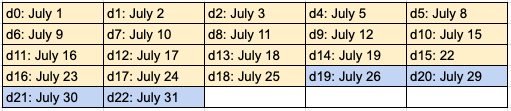

In [198]:
# four days of prediction
lastDay = len(df2021) - (24*4)
print(lastDay)

d1 = lastDay #day 19, July 26
d2 = d1 + 24 # day 20, July 29 
d3 = d2 + 24 #day 21, July 30
d4 = d3 + 24 # day 22, July 31

408


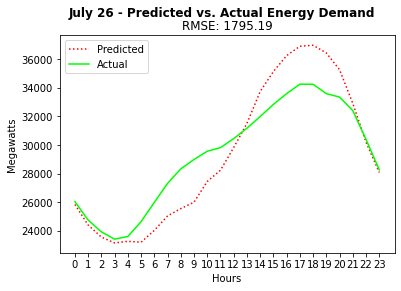

Percent error is:  [0.04858112]


In [199]:
########## DAY 1: D19, July 26
date_2021 = '20210726'
dayInJuly = 25
julyRep1 = printMonth_july(date_2021, dayInJuly)

day1 = df2021_clean.iloc[d1-window_size:d1+window_size,:]
lst_output_1 = futurePredictions_EC(bestEnergyConsumptionModel, day1, howManyFutureHours, window_size, numVarInputs)

megawattsScaler = allScalers[len(allScalers)-1]

predictedVals_1 = megawattsScaler.inverse_transform(np.array(lst_output_1).reshape(-1,1))
predicted24Hours_1 = pd.DataFrame(predictedVals_1)

rmse_1 = round(mean_squared_error(julyRep1, predicted24Hours_1, squared=False), 2)

plt.plot(predicted24Hours_1, color = 'red', label = 'Predicted', linestyle = 'dotted')
plt.plot(julyRep1, color = 'lime', label ='Actual')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Megawatts')
plt.suptitle('July 26 - Predicted vs. Actual Energy Demand', weight='bold')
plt.title("RMSE: " + str(rmse_1))
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/all/'
plt.savefig(pathToSaveData+'July26_predict_'+str(iteration)+'.jpg', bbox_inches = 'tight', dpi=150)
plt.show()
vals, res = percentageOf(predictedVals_1, list(julyRep1))
print("Percent error is: ", str(res))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


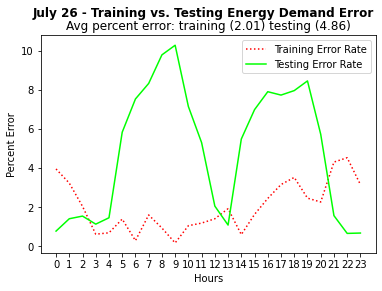

In [200]:
#day 19, July 26 ERROR
date_2019 = "20190726"
date_2020 = "20200726"
date_2021 = "20210726"
july_date = 25
training_ED1, testing_ED1 = getEnergy_july(date_2019, date_2020, date_2021, july_date)

training_error1, avg_training_error1 = percentageOf(predictedVals_1, training_ED1)
testing_error1, avg_testing_error1 = percentageOf(predictedVals_1, testing_ED1)
training_error1 = list(training_error1)
testing_error1 = list(testing_error1)
# in percentage, so mult by 100
for i in range(len(testing_error1)):
  testing_error1[i] *= 100
  training_error1[i] *= 100

# average percent error reformatted
avg_training_error1 = round(avg_training_error1.astype(float)[0] * 100, 2)
avg_testing_error1 = round(avg_testing_error1.astype(float)[0] * 100, 2)

plt.plot(training_error1, color = 'red', label = 'Training Error Rate', linestyle='dotted')
plt.plot(testing_error1, color = 'lime', label ='Testing Error Rate')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.legend()
plt.xlabel('Hours')
plt.ylabel('Percent Error')
plt.suptitle('July 26 - Training vs. Testing Energy Demand Error', weight='bold')
plt.title("Avg percent error: " + "training (" + str(avg_training_error1) + ") testing ("+str(avg_testing_error1)+")")
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/all/'
plt.savefig(pathToSaveData+'July26_error_'+ str(iteration)+'.jpg', bbox_inches = 'tight', dpi=150)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


July 26


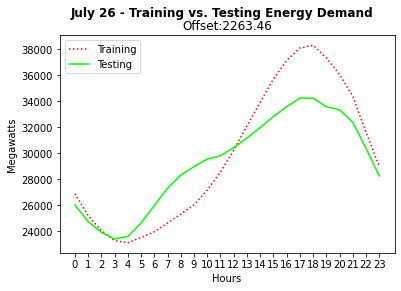

In [201]:
just_energyDemand(date_2019, date_2020, date_2021, july_date, iteration)

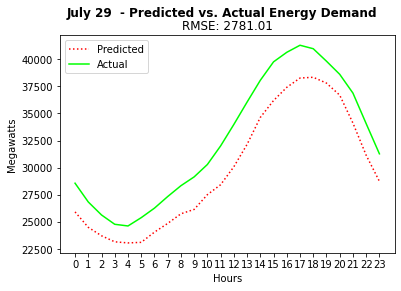

res is:  [0.08369809]


In [202]:
########## DAY 2: day 20, July 29 
date_2021 = '20210729'
dayInJuly = 28
julyRep2 = printMonth_july(date_2021, dayInJuly)

day2 = df2021_clean.iloc[d2-window_size:d2+window_size,:]
lst_output_2 = futurePredictions_EC(bestEnergyConsumptionModel, day2, howManyFutureHours, window_size, numVarInputs)

megawattsScaler = allScalers[len(allScalers)-1]

predictedVals_2 = megawattsScaler.inverse_transform(np.array(lst_output_2).reshape(-1,1))
predicted24Hours_2 = pd.DataFrame(predictedVals_2)

rmse_2 = round(mean_squared_error(julyRep2, predicted24Hours_2, squared=False), 2)

plt.plot(predicted24Hours_2, color = 'red', label = 'Predicted', linestyle="dotted")
plt.plot(julyRep2, color = 'lime', label ='Actual')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Megawatts')
plt.suptitle('July 29  - Predicted vs. Actual Energy Demand', weight='bold')
plt.title("RMSE: " + str(rmse_2))
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/all/'
plt.savefig(pathToSaveData+'July29_predict_'+str(iteration)+'.jpg', bbox_inches = 'tight', dpi=150)
plt.show()

allVals, res = percentageOf(predictedVals_2, list(julyRep2))
print("res is: ", res)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


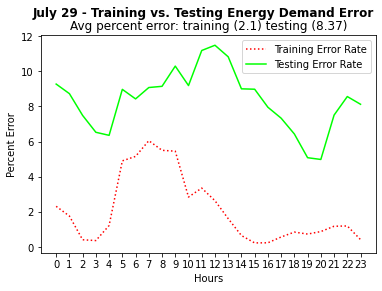

In [203]:
#day 20, July 29 ERROR
date_2019 = "20190729"
date_2020 = "20200729"
date_2021 = "20210729"
july_date = 28

training_ED2, testing_ED2 = getEnergy_july(date_2019, date_2020, date_2021, july_date)

training_error2, avg_training_error2 = percentageOf(predictedVals_2, training_ED2)
testing_error2, avg_testing_error2 = percentageOf(predictedVals_2, testing_ED2)
training_error2 = list(training_error2)
testing_error2 = list(testing_error2)
# in percentage, so mult by 100
for i in range(len(testing_error2)):
  testing_error2[i] *= 100
  training_error2[i] *= 100

# average percent error reformatted
avg_training_error2 = round(avg_training_error2.astype(float)[0] * 100, 2)
avg_testing_error2 = round(avg_testing_error2.astype(float)[0] * 100, 2)

plt.plot(training_error2, color = 'red', label = 'Training Error Rate', linestyle='dotted')
plt.plot(testing_error2, color = 'lime', label ='Testing Error Rate')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.legend()
plt.xlabel('Hours')
plt.ylabel('Percent Error')
plt.suptitle('July 29 - Training vs. Testing Energy Demand Error', weight='bold')
plt.title("Avg percent error: " + "training (" + str(avg_training_error2) + ") testing ("+str(avg_testing_error2)+")")
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/all/'
plt.savefig(pathToSaveData+'July29_error_'+str(iteration)+'.jpg', bbox_inches = 'tight', dpi=150)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


July 29


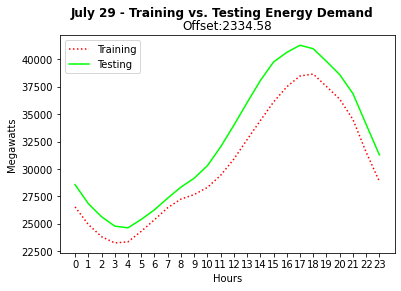

In [204]:
just_energyDemand(date_2019, date_2020, date_2021, july_date, iteration)

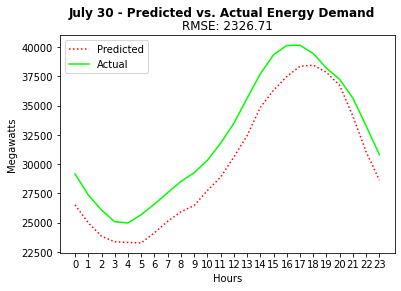

res is:  [0.07090545]


In [205]:
########## DAY 3: day 21, July 30
date_2021 = '20210730'
dayInJuly = 29
julyRep3 = printMonth_july(date_2021, dayInJuly)

day3 = df2021_clean.iloc[d3-window_size:d3+window_size,:]
lst_output_3 = futurePredictions_EC(bestEnergyConsumptionModel, day3, howManyFutureHours, window_size, numVarInputs)

megawattsScaler = allScalers[len(allScalers)-1]

predictedVals_3 = megawattsScaler.inverse_transform(np.array(lst_output_3).reshape(-1,1))
predicted24Hours_3 = pd.DataFrame(predictedVals_3)

rmse_3 = round(mean_squared_error(julyRep3, predicted24Hours_3, squared=False), 2)

plt.plot(predicted24Hours_3, color = 'red', label = 'Predicted', linestyle="dotted")
plt.plot(julyRep3, color = 'lime', label ='Actual')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Megawatts')
plt.suptitle('July 30 - Predicted vs. Actual Energy Demand', weight='bold')
plt.title("RMSE: " + str(rmse_3))
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/all/'
plt.savefig(pathToSaveData+'July30_predict_'+str(iteration)+'.jpg', bbox_inches = 'tight', dpi=150) 
plt.show()

vals, res = percentageOf(predictedVals_3, list(julyRep3))
print("res is: ", str(res))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


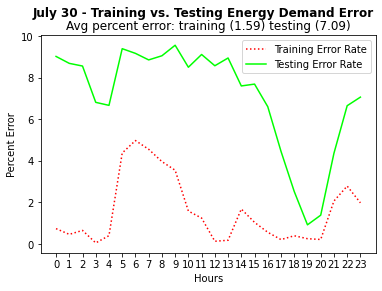

In [206]:
#day 21, July 30
date_2019 = "20190730"
date_2020 = "20200730"
date_2021 = "20210730"
july_date = 29

training_ED3, testing_ED3 = getEnergy_july(date_2019, date_2020, date_2021, july_date)

training_error3, avg_training_error3 = percentageOf(predictedVals_3, training_ED3)
testing_error3, avg_testing_error3 = percentageOf(predictedVals_3, testing_ED3)

training_error3 = list(training_error3)
testing_error3 = list(testing_error3)
# in percentage, so mult by 100
for i in range(len(testing_error3)):
  testing_error3[i] *= 100
  training_error3[i] *= 100

# average percent error reformatted
avg_training_error3 = round(avg_training_error3.astype(float)[0] * 100, 2)
avg_testing_error3 = round(avg_testing_error3.astype(float)[0] * 100, 2)

plt.plot(training_error3, color = 'red', label = 'Training Error Rate', linestyle='dotted')
plt.plot(testing_error3, color = 'lime', label ='Testing Error Rate')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.legend()
plt.xlabel('Hours')
plt.ylabel('Percent Error')
plt.suptitle('July 30 - Training vs. Testing Energy Demand Error', weight='bold')
plt.title("Avg percent error: " + "training (" + str(avg_training_error3) + ") testing ("+str(avg_testing_error3)+")")
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/all/'
plt.savefig(pathToSaveData+'July30_error_'+str(iteration)+'.jpg', bbox_inches = 'tight', dpi=150)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


July 30


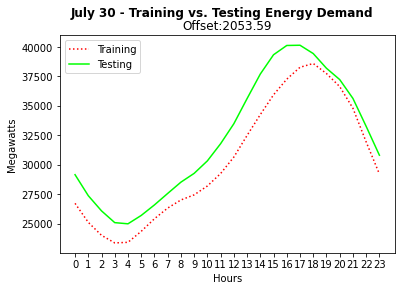

In [207]:
just_energyDemand(date_2019, date_2020, date_2021, july_date, iteration)

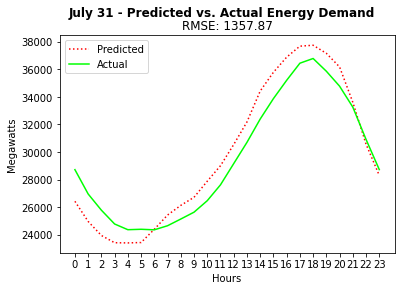

res is:  [0.04221116]


In [208]:
########## DAY 4:  day 22, July 31
date_2021 = '20210731'
dayInJuly = 30 #0->june 1, so it is date -1 
julyRep4 = printMonth_july(date_2021, dayInJuly)

day4 = df2021_clean.iloc[d4-window_size:d4+window_size,:]
lst_output_4 = futurePredictions_EC(bestEnergyConsumptionModel, day4, howManyFutureHours, window_size, numVarInputs)

megawattsScaler = allScalers[len(allScalers)-1]

predictedVals_4 = megawattsScaler.inverse_transform(np.array(lst_output_4).reshape(-1,1))
predicted24Hours_4 = pd.DataFrame(predictedVals_4)

rmse_4 = round(mean_squared_error(julyRep4, predicted24Hours_4, squared=False), 2)

plt.plot(predicted24Hours_4, color = 'red',  label = 'Predicted', linestyle="dotted")
plt.plot(julyRep4, color = 'lime', label ='Actual')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Megawatts')
plt.suptitle('July 31 - Predicted vs. Actual Energy Demand', weight='bold')
plt.title("RMSE: " + str(rmse_4))
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/all/'
plt.savefig(pathToSaveData+'July31_predict_'+str(iteration)+'.jpg', bbox_inches = 'tight', dpi=150)
plt.show()

val, res = percentageOf(predictedVals_4, list(julyRep4))
print("res is: ", str(res))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


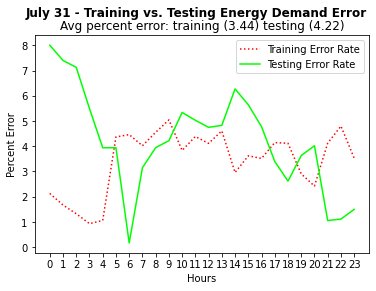

In [209]:
# day 22, July 31
date_2019 = "20190731"
date_2020 = "20200731"
date_2021 = "20210731"
july_date = 30

training_ED4, testing_ED4 = getEnergy_july(date_2019, date_2020, date_2021, july_date)

training_error4, avg_training_error4 = percentageOf(predictedVals_4, training_ED4)
testing_error4, avg_testing_error4 = percentageOf(predictedVals_4, testing_ED4)
training_error4 = list(training_error4)
testing_error4 = list(testing_error4)
# in percentage, so mult by 100
for i in range(len(testing_error4)):
  testing_error4[i] *= 100
  training_error4[i] *= 100

# average percent error reformatted
avg_training_error4 = round(avg_training_error4.astype(float)[0] * 100, 2)
avg_testing_error4 = round(avg_testing_error4.astype(float)[0] * 100, 2)

plt.plot(training_error4, color = 'red', label = 'Training Error Rate', linestyle='dotted')
plt.plot(testing_error4, color = 'lime', label ='Testing Error Rate')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.legend()
plt.xlabel('Hours')
plt.ylabel('Percent Error')
plt.suptitle('July 31 - Training vs. Testing Energy Demand Error', weight='bold')
plt.title("Avg percent error: " + "training (" + str(avg_training_error4) + ") testing ("+str(avg_testing_error4)+")")
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/all/'
plt.savefig(pathToSaveData+'July31_error_'+str(iteration)+'.jpg', bbox_inches = 'tight', dpi=150)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


July 31


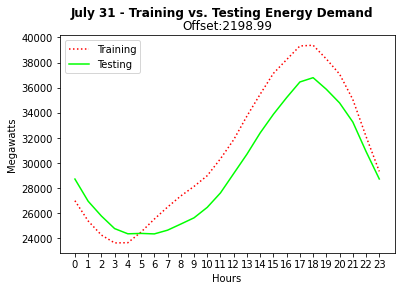

In [210]:
just_energyDemand(date_2019, date_2020, date_2021, july_date, iteration)

# Be careful

In [177]:
H_48_training = []
H_48_testing = []
H_72_training = []
H_72_testing = []
H_96_training = []
H_96_testing = []

In [178]:
H_48_training_error = []
H_48_testing_error = []
H_72_training_error = []
H_72_testing_error = []
H_96_training_error = []
H_96_testing_error = []

In [179]:
###################48 hours
#training errors
H_48_training.append(training_error1) #july 26
H_48_training.append(training_error2) #july 29
H_48_training.append(training_error3) #july 30
H_48_training.append(training_error4) #july 31

# testing errors
H_48_testing.append(testing_error1) #july 26
H_48_testing.append(testing_error2) #july 29
H_48_testing.append(testing_error3) #july 30
H_48_testing.append(testing_error4) #july 31

#average training error
H_48_training_error.append(avg_training_error1) #july 26
H_48_training_error.append(avg_training_error2) #july 29
H_48_training_error.append(avg_training_error3) #july 30
H_48_training_error.append(avg_training_error4) #july 31

#average testing error
H_48_testing_error.append(avg_testing_error1) #july 26
H_48_testing_error.append(avg_testing_error2) #july 29
H_48_testing_error.append(avg_testing_error3) #july 30
H_48_testing_error.append(avg_testing_error3) #july 31

In [195]:
###################72 hours
#training errors
H_72_training.append(training_error1) #july 26
H_72_training.append(training_error2) #july 29
H_72_training.append(training_error3) #july 30
H_72_training.append(training_error4) #july 31

# testing errors
H_72_testing.append(testing_error1) #july 26
H_72_testing.append(testing_error2) #july 29
H_72_testing.append(testing_error3) #july 30
H_72_testing.append(testing_error4) #july 31

#average training error
H_72_training_error.append(avg_training_error1) #july 26
H_72_training_error.append(avg_training_error2) #july 29
H_72_training_error.append(avg_training_error3) #july 30
H_72_training_error.append(avg_training_error4) #july 31

#average testing error
H_72_testing_error.append(avg_testing_error1) #july 26
H_72_testing_error.append(avg_testing_error2) #july 29
H_72_testing_error.append(avg_testing_error3) #july 30
H_72_testing_error.append(avg_testing_error4) #july 31

In [211]:
###################96 hours
#training errors
H_96_training.append(training_error1) #july 26
H_96_training.append(training_error2) #july 29
H_96_training.append(training_error3) #july 30
H_96_training.append(training_error4) #july 31

# testing errors
H_96_testing.append(testing_error1) #july 26
H_96_testing.append(testing_error2) #july 29
H_96_testing.append(testing_error3) #july 30
H_96_testing.append(testing_error4) #july 31

#average training error
H_96_training_error.append(avg_training_error1) #july 26
H_96_training_error.append(avg_training_error2) #july 29
H_96_training_error.append(avg_training_error3) #july 30
H_96_training_error.append(avg_training_error4) #july 31

#average testing error
H_96_testing_error.append(avg_testing_error1) #july 26
H_96_testing_error.append(avg_testing_error2) #july 29
H_96_testing_error.append(avg_testing_error3) #july 30
H_96_testing_error.append(avg_testing_error4) #july 31

In [62]:
H_48_training[0]

[array([5.857945], dtype=float32),
 array([4.376821], dtype=float32),
 array([1.5101144], dtype=float32),
 array([0.82428527], dtype=float32),
 array([1.8427767], dtype=float32),
 array([2.1741607], dtype=float32),
 array([3.3120365], dtype=float32),
 array([5.615998], dtype=float32),
 array([6.8992534], dtype=float32),
 array([5.063721], dtype=float32),
 array([2.9122121], dtype=float32),
 array([0.36907166], dtype=float32),
 array([0.6861535], dtype=float32),
 array([2.5804274], dtype=float32),
 array([3.886468], dtype=float32),
 array([4.5768056], dtype=float32),
 array([5.1155663], dtype=float32),
 array([5.341924], dtype=float32),
 array([5.5997286], dtype=float32),
 array([5.1000724], dtype=float32),
 array([5.3047514], dtype=float32),
 array([6.524911], dtype=float32),
 array([5.5601935], dtype=float32),
 array([5.520952], dtype=float32)]

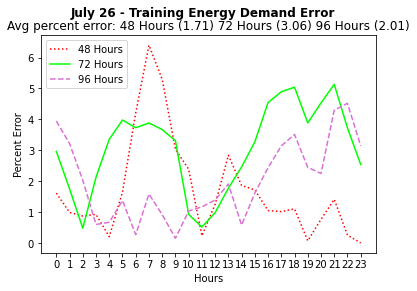

In [212]:
##########july 26 - training error
plt.plot(H_48_training[0], color = 'red', label = '48 Hours', linestyle='dotted')
plt.plot(H_72_training[0], color = 'lime', label = '72 Hours')
plt.plot(H_96_training[0], color = 'orchid', label = '96 Hours', linestyle='dashed')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Percent Error')
plt.suptitle('July 26 - Training Energy Demand Error', weight='bold')
plt.title("Avg percent error: " + "48 Hours (" + str(H_48_training_error[0]) + ") 72 Hours (" + str(H_72_training_error[0])
              +") 96 Hours ("+str(H_96_training_error[0])+")")
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/all/'
plt.savefig(pathToSaveData+'July26_AllHours_trainingError.jpg', bbox_inches = 'tight', dpi=150)
plt.show()


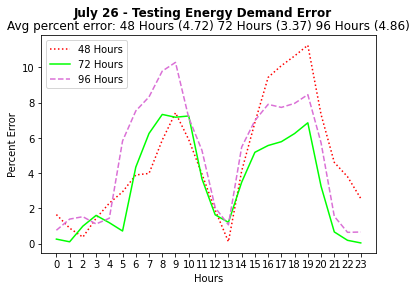

In [213]:
##########july 26 - testing error
plt.plot(H_48_testing[0], color = 'red', label = '48 Hours', linestyle='dotted')
plt.plot(H_72_testing[0], color = 'lime', label = '72 Hours')
plt.plot(H_96_testing[0], color = 'orchid', label = '96 Hours', linestyle='dashed')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Percent Error')
plt.suptitle('July 26 - Testing Energy Demand Error', weight='bold')
plt.title("Avg percent error: " + "48 Hours (" + str(H_48_testing_error[0]) + ") 72 Hours (" + str(H_72_testing_error[0])
          +") 96 Hours ("+str(H_96_testing_error[0])+")")
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/all/'
plt.savefig(pathToSaveData+'July26_AllHours_testingError.jpg', bbox_inches = 'tight', dpi=150)
plt.show()


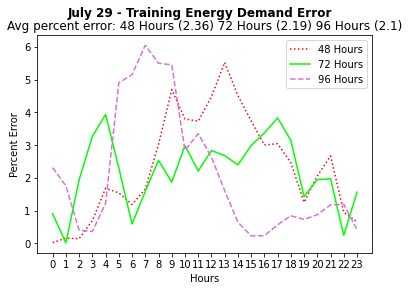

In [214]:
##########july 29 - training error
plt.plot(H_48_training[1], color = 'red', label = '48 Hours', linestyle='dotted')
plt.plot(H_72_training[1], color = 'lime', label = '72 Hours')
plt.plot(H_96_training[1], color = 'orchid', label = '96 Hours', linestyle='dashed')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Percent Error')
plt.suptitle('July 29 - Training Energy Demand Error', weight='bold')
plt.title("Avg percent error: " + "48 Hours (" + str(H_48_training_error[1]) + ") 72 Hours (" + str(H_72_training_error[1])
              +") 96 Hours ("+str(H_96_training_error[1])+")")
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/all/'
plt.savefig(pathToSaveData+'July29_AllHours_trainingError.jpg', bbox_inches = 'tight', dpi=150)
plt.show()


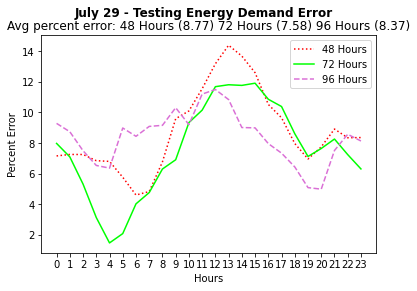

In [215]:
##########july 29 - testing error
plt.plot(H_48_testing[1], color = 'red', label = '48 Hours', linestyle='dotted')
plt.plot(H_72_testing[1], color = 'lime', label = '72 Hours')
plt.plot(H_96_testing[1], color = 'orchid', label = '96 Hours', linestyle='dashed')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Percent Error')
plt.suptitle('July 29 - Testing Energy Demand Error', weight='bold')
plt.title("Avg percent error: " + "48 Hours (" + str(H_48_testing_error[1]) + ") 72 Hours (" + str(H_72_testing_error[1])
          +") 96 Hours ("+str(H_96_testing_error[1])+")")
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/all/'
plt.savefig(pathToSaveData+'July29_AllHours_testingError.jpg', bbox_inches = 'tight', dpi=150)
plt.show()


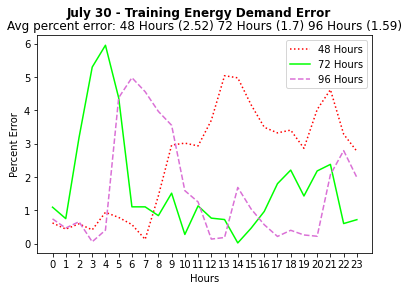

In [216]:
##########july 30 - training error
plt.plot(H_48_training[2], color = 'red', label = '48 Hours', linestyle='dotted')
plt.plot(H_72_training[2], color = 'lime', label = '72 Hours')
plt.plot(H_96_training[2], color = 'orchid', label = '96 Hours', linestyle='dashed')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Percent Error')
plt.suptitle('July 30 - Training Energy Demand Error', weight='bold')
plt.title("Avg percent error: " + "48 Hours (" + str(H_48_training_error[2]) + ") 72 Hours (" + str(H_72_training_error[2])
              +") 96 Hours ("+str(H_96_training_error[2])+")")
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/all/'
plt.savefig(pathToSaveData+'July30_AllHours_trainingError.jpg', bbox_inches = 'tight', dpi=150)
plt.show()


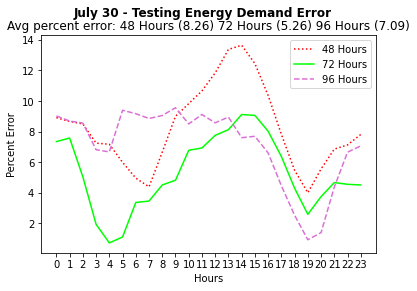

In [217]:
##########july 30 - testing error
plt.plot(H_48_testing[2], color = 'red', label = '48 Hours', linestyle='dotted')
plt.plot(H_72_testing[2], color = 'lime', label = '72 Hours')
plt.plot(H_96_testing[2], color = 'orchid', label = '96 Hours', linestyle='dashed')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Percent Error')
plt.suptitle('July 30 - Testing Energy Demand Error', weight='bold')
plt.title("Avg percent error: " + "48 Hours (" + str(H_48_testing_error[2]) + ") 72 Hours (" + str(H_72_testing_error[2])
          +") 96 Hours ("+str(H_96_testing_error[2])+")")
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/all/'
plt.savefig(pathToSaveData+'July30_AllHours_testingError.jpg', bbox_inches = 'tight', dpi=150)
plt.show()


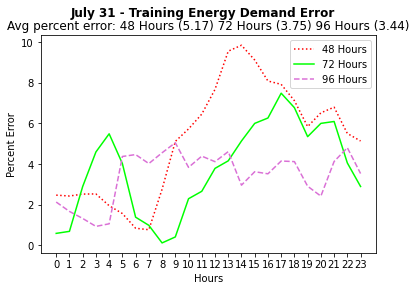

In [218]:
##########july 31 - training error
plt.plot(H_48_training[3], color = 'red', label = '48 Hours', linestyle='dotted')
plt.plot(H_72_training[3], color = 'lime', label = '72 Hours')
plt.plot(H_96_training[3], color = 'orchid', label = '96 Hours', linestyle='dashed')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Percent Error')
plt.suptitle('July 31 - Training Energy Demand Error', weight='bold')
plt.title("Avg percent error: " + "48 Hours (" + str(H_48_training_error[3]) + ") 72 Hours (" + str(H_72_training_error[3])
              +") 96 Hours ("+str(H_96_training_error[3])+")")
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/all/'
plt.savefig(pathToSaveData+'July31_AllHours_trainingError.jpg', bbox_inches = 'tight', dpi=150)
plt.show()


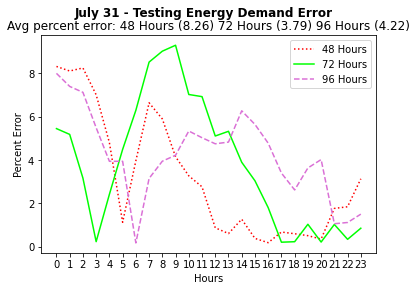

In [219]:
##########july 30 - testing error
plt.plot(H_48_testing[3], color = 'red', label = '48 Hours', linestyle='dotted')
plt.plot(H_72_testing[3], color = 'lime', label = '72 Hours')
plt.plot(H_96_testing[3], color = 'orchid', label = '96 Hours', linestyle='dashed')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Percent Error')
plt.suptitle('July 31 - Testing Energy Demand Error', weight='bold')
plt.title("Avg percent error: " + "48 Hours (" + str(H_48_testing_error[3]) + ") 72 Hours (" + str(H_72_testing_error[3])
          +") 96 Hours ("+str(H_96_testing_error[3])+")")
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-3/all/'
plt.savefig(pathToSaveData+'July31_AllHours_testingError.jpg', bbox_inches = 'tight', dpi=150)
plt.show()

In [220]:
# july 26
# find the min difference between the three time sections
# the distance between 72 -> 48 + the distance between 96 -> 48
dayPos = 0

H_48_testing_list = list(H_48_testing)
H_72_testing_list = list(H_72_testing)
H_96_testing_list = list(H_96_testing)

july26_min = {}
for i in range(24):
  m = 0
  m+=abs(H_72_testing_list[dayPos][i] - H_48_testing_list[dayPos][i])
  m+=abs(H_72_testing_list[dayPos][i] - H_96_testing_list[dayPos][i])
  july26_min[i]= m

# sorted(july26_min, key=july26_min.get)

In [221]:
# july 29
# find the min difference between the three time sections
# the distance between 72 -> 48 + the distance between 96 -> 48
dayPos = 1

H_48_testing_list = list(H_48_testing)
H_72_testing_list = list(H_72_testing)
H_96_testing_list = list(H_96_testing)

july29_min = {}
for i in range(24):
  m = 0
  m+=abs(H_72_testing_list[dayPos][i] - H_48_testing_list[dayPos][i])
  m+=abs(H_72_testing_list[dayPos][i] - H_96_testing_list[dayPos][i])
  july29_min[i]= m

# sorted(july29_min, key=july29_min.get)

In [222]:
# july 30
# find the min difference between the three time sections
# the distance between 72 -> 48 + the distance between 96 -> 48
dayPos = 2

H_48_testing_list = list(H_48_testing)
H_72_testing_list = list(H_72_testing)
H_96_testing_list = list(H_96_testing)

july30_min = {}
for i in range(24):
  m = 0
  m+=abs(H_72_testing_list[dayPos][i] - H_48_testing_list[dayPos][i])
  m+=abs(H_72_testing_list[dayPos][i] - H_96_testing_list[dayPos][i])
  july30_min[i]= m

# sorted(july30_min, key=july30_min.get)

In [223]:
# july 31
# find the min difference between the three time sections
# the distance between 72 -> 48 + the distance between 96 -> 48
dayPos = 3

H_48_testing_list = list(H_48_testing)
H_72_testing_list = list(H_72_testing)
H_96_testing_list = list(H_96_testing)

july31_min = {}
for i in range(24):
  m = 0
  m+=abs(H_72_testing_list[dayPos][i] - H_48_testing_list[dayPos][i])
  m+=abs(H_72_testing_list[dayPos][i] - H_96_testing_list[dayPos][i])
  july31_min[i]= m

# sorted(july31_min, key=july31_min.get)

In [224]:
#hour 0 -> 5, july 26
minOf1= {}
theHours = [H_48_testing_list, H_72_testing_list, H_96_testing_list]
day = 0
for m in range(0,3): # 48, 72, 96
    currentHour = theHours[m]
    tempMin = 0
    for i in range(0,6): #hour 0 -> 5
      tempMin+= currentHour[day][i]
    minOf1[m] = tempMin

minOf2= {}

for m in range(0,3): # 48, 72, 96
    currentHour = theHours[m]
    tempMin = 0
    for i in range(6,19): #hour 0 -> 5
      tempMin+= currentHour[day][i]
    minOf2[m] = tempMin

minOf3= {}

for m in range(0,3): # 48, 72, 96
    currentHour = theHours[m]
    tempMin = 0
    for i in range(18,23): #hour 0 -> 5
      tempMin+= currentHour[day][i]
    minOf3[m] = tempMin

res = (min(minOf3.values()) + min(minOf2.values()) + min(minOf1.values()))/24
print("New min error rate for July 26: ", str(res))

New min error rate for July 26:  [3.6322477]


In [225]:
#hour 0 -> 5, july 29
minOf1= {}
theHours = [H_48_testing_list, H_72_testing_list, H_96_testing_list]
day = 1
for m in range(0,3): # 48, 72, 96
    currentHour = theHours[m]
    tempMin = 0
    for i in range(0,6): #hour 0 -> 5
      tempMin+= currentHour[day][i]
    minOf1[m] = tempMin

minOf2= {}

for m in range(0,3): # 48, 72, 96
    currentHour = theHours[m]
    tempMin = 0
    for i in range(6,19): #hour 0 -> 5
      tempMin+= currentHour[day][i]
    minOf2[m] = tempMin

minOf3= {}

for m in range(0,3): # 48, 72, 96
    currentHour = theHours[m]
    tempMin = 0
    for i in range(18,23): #hour 0 -> 5
      tempMin+= currentHour[day][i]
    minOf3[m] = tempMin

res = (min(minOf3.values()) + min(minOf2.values()) + min(minOf1.values()))/24
print("New min error rate for July 29: ", str(res))

New min error rate for July 29:  [7.413503]


In [226]:
#hour 0 -> 5, july 30
minOf1= {}
theHours = [H_48_testing_list, H_72_testing_list, H_96_testing_list]
day = 2
for m in range(0,3): # 48, 72, 96
    currentHour = theHours[m]
    tempMin = 0
    for i in range(0,6): #hour 0 -> 5
      tempMin+= currentHour[day][i]
    minOf1[m] = tempMin

minOf2= {}

for m in range(0,3): # 48, 72, 96
    currentHour = theHours[m]
    tempMin = 0
    for i in range(6,19): #hour 0 -> 5
      tempMin+= currentHour[day][i]
    minOf2[m] = tempMin

minOf3= {}

for m in range(0,3): # 48, 72, 96
    currentHour = theHours[m]
    tempMin = 0
    for i in range(18,23): #hour 0 -> 5
      tempMin+= currentHour[day][i]
    minOf3[m] = tempMin

res = (min(minOf3.values()) + min(minOf2.values()) + min(minOf1.values()))/24
print("New min error rate for July 30: ", str(res))

New min error rate for July 30:  [5.0888944]


In [227]:
#hour 0 -> 5, july 31
minOf1= {}
theHours = [H_48_testing_list, H_72_testing_list, H_96_testing_list]
day = 3
for m in range(0,3): # 48, 72, 96
    currentHour = theHours[m]
    tempMin = 0
    for i in range(0,6): #hour 0 -> 5
      tempMin+= currentHour[day][i]
    minOf1[m] = tempMin

minOf2= {}

for m in range(0,3): # 48, 72, 96
    currentHour = theHours[m]
    tempMin = 0
    for i in range(6,19): #hour 0 -> 5
      tempMin+= currentHour[day][i]
    minOf2[m] = tempMin

minOf3= {}

for m in range(0,3): # 48, 72, 96
    currentHour = theHours[m]
    tempMin = 0
    for i in range(18,23): #hour 0 -> 5
      tempMin+= currentHour[day][i]
    minOf3[m] = tempMin

res = (min(minOf3.values()) + min(minOf2.values()) + min(minOf1.values()))/24
print("New min error rate for July 31: ", str(res))

New min error rate for July 31:  [2.288985]


In [228]:
#keeps colab from sleeping
while True:pass

KeyboardInterrupt: ignored